In [2]:
from gdc.data_access import *
from gdc.pricing import compute_simulated_base_variable_profit_ht, get_base_price
from gdc.utils import GDC_DATA_PATH
import pandas as pd
from os import path
import numpy as np

In [3]:
df_load_simulated_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-01-01 00:00:00,0.308875,0.241084,0.435789,0.424829,0.239696,0.618679,0.201332,0.002316,0.537362,0.863129,...,0.848488,0.609326,0.750540,0.509708,0.675622,0.224907,1.116675,0.979219,1.214080,1.667707
2023-01-01 01:00:00,0.325552,0.246717,0.424862,0.387153,2.523461,0.619000,0.220604,1.393032,1.130548,0.721798,...,6.277924,0.935558,0.704712,0.445823,0.709091,0.192008,1.053277,0.809944,1.277540,5.152804
2023-01-01 02:00:00,3.468337,0.245007,2.300304,0.389507,0.987357,2.315828,2.433891,0.151374,0.877162,0.589248,...,1.191456,1.541097,0.711532,0.605748,0.757926,0.215429,0.839848,0.714650,1.375509,6.028554
2023-01-01 03:00:00,2.215840,1.272533,2.411101,0.382058,0.542293,1.898651,0.208088,0.123750,0.581648,0.515496,...,1.093116,1.073977,0.719326,1.533871,0.714349,0.228124,0.816399,1.518087,2.130233,4.159936
2023-01-01 04:00:00,1.259481,1.027133,0.483457,0.393334,0.380745,2.999703,0.152132,0.158867,1.667804,0.507242,...,1.070443,0.826959,0.757065,0.524391,0.865323,0.203812,0.809643,0.820883,6.877547,3.808041


In [4]:
df_hourly_prices.head()

,Price_EUR_MWh
date,
2023-01-01 00:00:00,-0.10
2023-01-01 01:00:00,-1.33
2023-01-01 02:00:00,-4.08
2023-01-01 03:00:00,-4.16
2023-01-01 04:00:00,-3.58


<Axes: xlabel='date'>

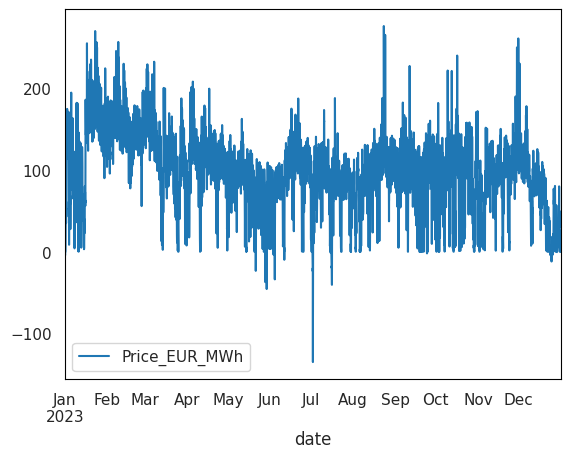

In [5]:
df_hourly_prices.plot()

In [6]:
df_labels['Power'].head()

0    6
1    6
2    6
3    6
4    6
Name: Power, dtype: int64

In [7]:
def get_subscribers(subscribed_power=6):
    return df_labels.loc[df_labels['Power'] == subscribed_power].index

In [8]:
get_subscribers()

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903],
      dtype='int64', length=3309)

In [10]:
dic_loads_by_power = {}

for p in [6, 9, 12]:
    this_loads = df_load_simulated_normalized.loc[:, get_subscribers(p)]
    dic_loads_by_power[p] = compute_simulated_base_variable_profit_ht(p, this_loads, df_hourly_prices)

In [11]:
dic_loads_by_power[6].head()[[0, 1]]

,0,1
2023-01-01 00:00:00,0.042470,0.033149
2023-01-01 01:00:00,0.045164,0.034227
2023-01-01 02:00:00,0.490700,0.034664
2023-01-01 03:00:00,0.313674,0.180140
2023-01-01 04:00:00,0.177562,0.144805


In [12]:
110.76/ (365)

0.3034520547945206

In [13]:
110.76/ (365 * 24)

0.012643835616438356

In [14]:
(0.1374 - np.array([-0.10, -1.33, -4.08])/1000 )  * np.array([0.308875, 0.325552, 3.468337]) 

array([0.04247031, 0.04516383, 0.49070032])